In [20]:
import os
import numpy as np
import pandas as pd
from PIL import Image
import cv2

# 路径定义
data_dir = './videos/MRI515_T2'
# data_dir = './videos/MRI515_T1'
# data_dir = 'videos/AFL_MRI'
# data_dir = './videos/bed_rest_MRI'

label_dir = os.path.join(data_dir,'label_in_png_L4L5_renamed')

# prompt_dir = 'manual_prompt_frame0'
# # prompt_dir ='manual_prompt_frame0_1'
prompt_dir ='manual_prompt_frame0_1_2'

auto_seg_dirs = { 
    "nolap": os.path.join(data_dir, prompt_dir, 'SAM2_seg_mask_nolap'),
    "yeslap": os.path.join(data_dir, prompt_dir, 'SAM2_seg_mask_yeslap')
}
csv_write_path = os.path.join(data_dir, prompt_dir, f"{prompt_dir}_dsc_overlap.csv")

# 确保目录存在
if not all(os.path.exists(d) for d in [label_dir] + list(auto_seg_dirs.values())):
    raise FileNotFoundError("Missing required directories!")

# 计算 DSC 和 Overlap
def calculate_metric(mask1, mask2, metric="dsc"):
    intersection = np.sum((mask1 > 0) & (mask2 > 0))
    total_area = np.sum(mask1 > 0) + np.sum(mask2 > 0)
    return (2 * intersection / total_area) if metric == "dsc" else (intersection / total_area) if total_area > 0 else 0.0

# 类别定义
class_ranges = {1: (30, 70), 2: (80, 120), 3: (130, 170), 4: (180, 220)}
# class_ranges = {1: (30, 70), 2: (80, 120)}

# 处理所有文件
results = []
for label_file in os.listdir(label_dir):
    label_index = int(label_file.split('.')[0])
    label_mask = np.array(Image.open(os.path.join(label_dir, label_file)))

    # 读取 segmentation masks（如果缺失则跳过）
    masks = {k: {} for k in auto_seg_dirs}
    missing_files = False
    for k, v in auto_seg_dirs.items():
        for c in class_ranges:
            mask_path = os.path.join(v, f"frame_{label_index}_obj_{c}.png")
            if os.path.exists(mask_path):
                masks[k][c] = np.array(Image.open(mask_path))
            else:
                print(f"Missing file: {mask_path}")
                missing_files = True
                break  # 发现缺失文件，跳过该 `label_file`
    if missing_files:
        continue

    file_results = {"file_name": label_file}
    
    for c, (low, high) in class_ranges.items():
        label_bin = ((low <= label_mask) & (label_mask <= high)).astype(np.uint8)  # 转换为 uint8

        # 处理 nolap 和 yeslap segmentation masks
        for seg_type in ["nolap", "yeslap"]:
            mask_bin = ((low <= masks[seg_type][c]) & (masks[seg_type][c] <= high)).astype(np.uint8)
            masks[seg_type][c] = cv2.resize(mask_bin, label_bin.shape[::-1], interpolation=cv2.INTER_NEAREST)

        file_results.update({
            f"class{c}_dsc": calculate_metric(label_bin, masks["nolap"][c], "dsc"),
            f"class{c}_label_area": np.sum(label_bin),
            f"class{c}_auto_area": np.sum(masks["nolap"][c])
        })

    # 计算 Overlap Ratio（使用 yeslap）
    file_results["overlap_ratio"] = calculate_metric(masks["yeslap"][1], masks["yeslap"][2], "overlap")

    results.append(file_results)
#     print(f"Processed {label_file}: {file_results}")

# 保存 CSV
pd.DataFrame(results).to_csv(csv_write_path, index=False)


In [21]:
results_df = pd.DataFrame(results)
results_df.head()

file_name  class1_dsc  class1_label_area  class1_auto_area  class2_dsc  \
0  00261.png    0.953810               2602              2464    0.977146   
1  00212.png    0.970563               2964              2913    0.961295   
2  00378.png    0.957317               1988              1948    0.961097   
3  00071.png    0.949495               2483              2566    0.923691   
4  00328.png    0.967742               1890              1861    0.965845   

   class2_label_area  class2_auto_area  class3_dsc  class3_label_area  \
0               2427              2430    0.977246               2601   
1               1928              2025    0.972131               1801   
2               1783              1790    0.974687               1950   
3               2045              2214    0.966030               2013   
4               1174              1139    0.963021               1240   

   class3_auto_area  class4_dsc  class4_label_area  class4_auto_area  \
0              2585    0.939277               2552              2652   
1              1859    0.976526               3225              3165   
2              1961    0.903618               1755              1700   
3              2020    0.969755               2622              2635   
4              1302    0.952405               1869              2039   

   overlap_ratio  
0       0.000817  
1       0.003431  
2       0.108089  
3       0.013619  
4       0.002660

In [22]:
import pandas as pd

# 假设 results_df 已经被定义
# 定义需要移除的 frame indices，并格式化为 5 位数字
frame_idx = [0]
# frame_idx = [0, 1]

frame_idx = [0, 1,2]

frame_idx_patterns = [f"{str(idx).zfill(5)}" for idx in frame_idx]  # ['frame00000', 'frame00001', 'frame00002']

# 构造正则表达式（匹配任何一个 frameXXXXX）
regex_pattern = "|".join(frame_idx_patterns)

# 过滤掉包含这些 frameXXXXX 的行
filtered_results_df = results_df[~results_df['file_name'].str.contains(regex_pattern, regex=True)].copy()

# 显示过滤后的 DataFrame 形状
print("Filtered DataFrame shape:", filtered_results_df.shape)
print(results_df.shape)
print(filtered_results_df.shape)

# 预览前几行数据
filtered_results_df.head()


Filtered DataFrame shape: (408, 14)
(411, 14)
(408, 14)


file_name  class1_dsc  class1_label_area  class1_auto_area  class2_dsc  \
0  00261.png    0.953810               2602              2464    0.977146   
1  00212.png    0.970563               2964              2913    0.961295   
2  00378.png    0.957317               1988              1948    0.961097   
3  00071.png    0.949495               2483              2566    0.923691   
4  00328.png    0.967742               1890              1861    0.965845   

   class2_label_area  class2_auto_area  class3_dsc  class3_label_area  \
0               2427              2430    0.977246               2601   
1               1928              2025    0.972131               1801   
2               1783              1790    0.974687               1950   
3               2045              2214    0.966030               2013   
4               1174              1139    0.963021               1240   

   class3_auto_area  class4_dsc  class4_label_area  class4_auto_area  \
0              2585    0.939277               2552              2652   
1              1859    0.976526               3225              3165   
2              1961    0.903618               1755              1700   
3              2020    0.969755               2622              2635   
4              1302    0.952405               1869              2039   

   overlap_ratio  
0       0.000817  
1       0.003431  
2       0.108089  
3       0.013619  
4       0.002660

In [25]:
import numpy as np
from scipy.stats import ks_1samp, norm
from statsmodels.stats.weightstats import ttost_paired
from tqdm import tqdm

# 类别名称映射（可自定义）
class_names = {
    1: "Left_LES",    2: "Left_MF",    3: "Right_LES",    4: "Right_MF"}

# 参数
margin_pct = 0.3
n_bootstrap = 10000

# 存储结果
tost_results = {}

for i in range(1, 5):
    label_name = class_names[i]
    label = filtered_results_df[f'class{i}_label_area'].dropna().to_numpy()
    auto = filtered_results_df[f'class{i}_auto_area'].dropna().to_numpy()
    min_len = min(len(label), len(auto))

    if min_len == 0:
        print(f"==== Class: {label_name} ====")
        print("Insufficient data. Skipped.\n")
        continue

    label, auto = label[:min_len], auto[:min_len]
    diff = auto - label
    z = (diff - np.mean(diff)) / np.std(diff, ddof=1)
    ks_stat, ks_p = ks_1samp(z, norm.cdf)
    delta = np.mean(label) * margin_pct

    print(f"==== Class: {label_name} ====")
    print(f"Sample size: {min_len}")
    print(f"[KS normality] p = {ks_p:.4f}")

    if ks_p >= 0.05:
        # 正态 → TOST
        p_tost, (t_lo, p_lo, _), (t_hi, p_hi, _) = ttost_paired(auto, label, -delta, delta)
        tost_results[label_name] = {
            'method': 'parametric', 'p_tost': p_tost
        }
        print("→ Using parametric TOST")
        print(f"pTOST = {p_tost:.4f} {'✅ Equivalent' if p_tost < 0.05 else '❌ Not equivalent'}\n")
    else:
        # 非正态 → Bootstrap
        inside = 0
        for _ in tqdm(range(n_bootstrap), leave=False):
            idx = np.random.choice(len(diff), len(diff), replace=True)
            mean_diff = np.mean(diff[idx])
            if -delta < mean_diff < delta:
                inside += 1
        p_boot = 1 - (inside / n_bootstrap)
        tost_results[label_name] = {
            'method': 'bootstrap', 'p_tost': p_boot
        }
        print("→ Using bootstrap TOST")
        print(f"bootstrap pTOST = {p_boot:.4f} {'✅ Equivalent' if p_boot < 0.05 else '❌ Not equivalent'}\n")


==== Class: Left_LES ====
Sample size: 408
[KS normality] p = 0.0000


→ Using bootstrap TOST
bootstrap pTOST = 1.0000 ❌ Not equivalent

==== Class: Left_MF ====
Sample size: 408
[KS normality] p = 0.0000


→ Using bootstrap TOST
bootstrap pTOST = 1.0000 ❌ Not equivalent

==== Class: Right_LES ====
Sample size: 408
[KS normality] p = 0.0000


→ Using bootstrap TOST
bootstrap pTOST = 1.0000 ❌ Not equivalent

==== Class: Right_MF ====
Sample size: 408
[KS normality] p = 0.0000


→ Using bootstrap TOST
bootstrap pTOST = 1.0000 ❌ Not equivalent



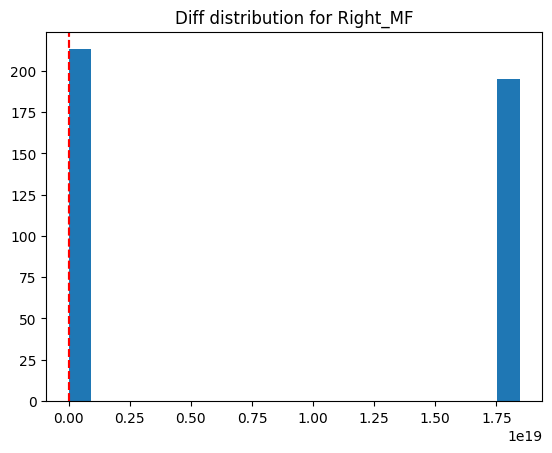

In [26]:
import matplotlib.pyplot as plt
plt.hist(diff, bins=20)
plt.axvline(-delta, color='r', linestyle='--')
plt.axvline(delta, color='r', linestyle='--')
plt.title(f'Diff distribution for {label_name}')
plt.show()


In [8]:
import numpy as np
import pandas as pd
from scipy.stats import pearsonr, ttest_ind, ks_2samp, shapiro

# 计算 4 类的 DSC 统计信息
dsc_stats = {}
for i in range(1, 5):
    dsc_values = filtered_results_df[f'class{i}_dsc'].dropna().to_numpy()
    
    if len(dsc_values) > 0:
        dsc_stats[f'class{i}'] = {
            'count': len(dsc_values),
            'max': np.max(dsc_values),
            'min': np.min(dsc_values),
            'mean': np.mean(dsc_values),
            'std': np.std(dsc_values)
        }

# 输出 DSC 统计信息
print("\nDSC Statistics: on len", len(dsc_values)  )
for class_name, stats in dsc_stats.items():
    print(f"{class_name}: Mean={stats['mean']:.3f}, Std={stats['std']:.3f}, Min={stats['min']:.3f}, Max={stats['max']:.6f}")




DSC Statistics: on len 42
class1: Mean=0.920, Std=0.043, Min=0.763, Max=0.975670
class2: Mean=0.910, Std=0.037, Min=0.816, Max=0.961170
class3: Mean=0.925, Std=0.040, Min=0.819, Max=0.973843
class4: Mean=0.922, Std=0.045, Min=0.780, Max=0.972004
